## **Import Libraries**

In [1]:
import tensorflow as tf
from tensorflow.keras.models import load_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing.image import load_img , img_to_array
from tensorflow.keras.layers import Dense , Dropout , Conv2D , MaxPooling2D, Flatten , BatchNormalization

from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
import seaborn as sns

## **Load Dataset**

In [2]:
(x_train , y_train) , (x_test , y_test) = tf.keras.datasets.cifar10.load_data()

In [3]:
print('Shape of x_train is {}'.format(x_train.shape))
print('Shape of x_test is {}'.format(x_test.shape))
print('Shape of y_train is {}'.format(y_train.shape))
print('Shape of y_test is {}'.format(y_test.shape))

Shape of x_train is (50000, 32, 32, 3)
Shape of x_test is (10000, 32, 32, 3)
Shape of y_train is (50000, 1)
Shape of y_test is (10000, 1)


## **Visualization**

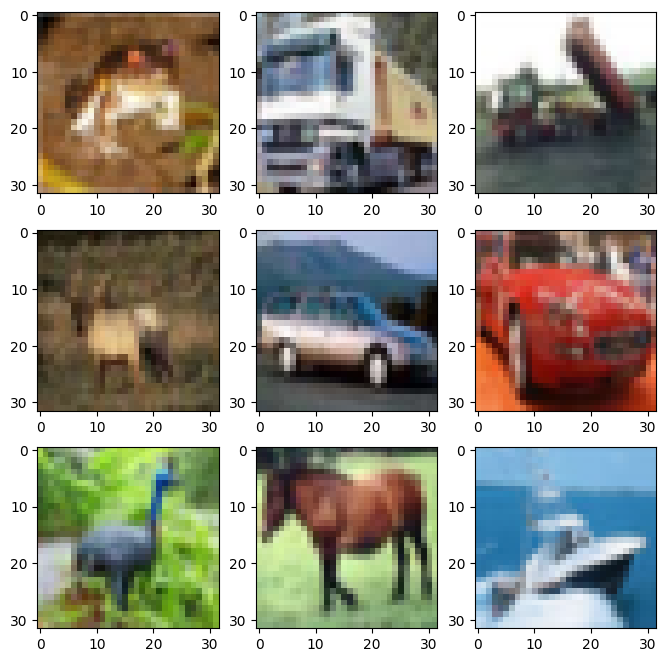

In [4]:
# create a grid of 3x3 images
plt.figure(figsize=(8,8))
for i in range(0,9):
    plt.subplot(330 + 1 + i)
    img = x_train[i]
    plt.imshow(img)
    
# show the plot
plt.show()

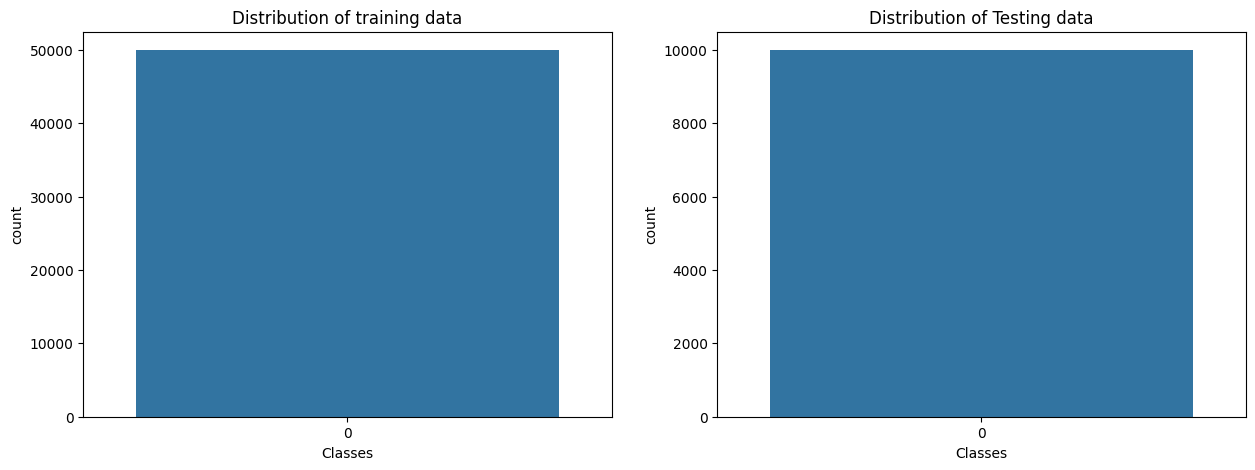

In [5]:
fig, axs = plt.subplots(1,2,figsize=(15,5)) 
# Count plot for training set
sns.countplot(y_train.ravel(), ax=axs[0])
axs[0].set_title('Distribution of training data')
axs[0].set_xlabel('Classes')
# Count plot for testing set
sns.countplot(y_test.ravel(), ax=axs[1])
axs[1].set_title('Distribution of Testing data')
axs[1].set_xlabel('Classes')
plt.show()

## **Preprocess and Splitting**

In [6]:
def normalize(x):
    x = x.astype('float32')
    x = x/255.0
    return x

datagen = ImageDataGenerator(
                            rotation_range=15,
                            width_shift_range=0.1,
                            height_shift_range=0.1,
                            horizontal_flip=True,
)

In [7]:
from sklearn.model_selection import train_test_split
x_test, x_val, y_test, y_val = train_test_split(x_test, y_test, test_size = 0.5, random_state = 0)

In [8]:
x_train = normalize(x_train)
x_test = normalize(x_test)
x_val = normalize(x_val)

y_train = tf.keras.utils.to_categorical(y_train , 10)
y_test = tf.keras.utils.to_categorical(y_test , 10)
y_val  = tf.keras.utils.to_categorical(y_val , 10)

datagen.fit(x_train)

In [9]:
print(x_train.shape)
print(y_train.shape)
print(y_test.shape)
print(y_val.shape)

(50000, 32, 32, 3)
(50000, 10)
(5000, 10)
(5000, 10)


## **Graph**

In [10]:
def results(model):
  epoch = 93

  epoch_range = range(1, epoch+1)
  plt.plot(epoch_range, history.history['accuracy'])
  plt.plot(epoch_range, history.history['val_accuracy'])
  plt.title('Classification Accuracy')
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.savefig("Classification Accuracy")
  plt.show()

  # Plot training & validation loss values
  plt.plot(epoch_range,history.history['loss'])
  plt.plot(epoch_range, history.history['val_loss'])
  plt.title('Model loss')
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Val'], loc='lower right')
  plt.savefig("Model loss")
  plt.show()

##**Model**

In [11]:
weight_decay = 1e-4
model = Sequential([
                    Conv2D(64, (3, 3), activation='relu', padding='same', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), input_shape=(32, 32, 3)),
                    BatchNormalization(),
                    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    Dropout(0.2),

                    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
                    BatchNormalization(),
                    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    Dropout(0.3),
 
                    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
                    BatchNormalization(),
                    Conv2D(256, (3, 3), activation='relu', kernel_regularizer=tf.keras.regularizers.l2(weight_decay), padding='same'),
                    BatchNormalization(),
                    MaxPooling2D((2, 2)),
                    Dropout(0.4),

                    Flatten(),
                    Dense(256, activation='relu'),
                    BatchNormalization(),
                    Dropout(0.5),
                    Dense(10, activation='softmax')                    
])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 64)        1792      
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 64)        36928     
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 64)       256       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 64)       0         
 )                                                               
                                                        

In [12]:
opt =    tf.keras.optimizers.Adam(learning_rate=0.001,beta_1=0.9,beta_2=0.999)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

In [13]:
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
callbacks = [ ReduceLROnPlateau(monitor='val_loss', 
                                patience=10,
                                cooldown=1,
                                verbose=1),
              EarlyStopping(monitor='val_loss',
                            min_delta=1e-4,
                            patience=15)]

In [14]:
# epoch = 200
epoch = 5
history = model.fit(datagen.flow(x_train , y_train , batch_size = 64), epochs = epoch, steps_per_epoch=len(x_train)/64, validation_data = (x_val , y_val) , verbose = 1, callbacks=callbacks)

Epoch 1/5
781/781 [==============================] - 316s 401ms/step - loss: 1.7771 - accuracy: 0.4273 - val_loss: 1.7178 - val_accuracy: 0.4822 - lr: 0.0010
Epoch 2/5
781/781 [==============================] - 310s 397ms/step - loss: 1.1731 - accuracy: 0.6118 - val_loss: 0.9611 - val_accuracy: 0.6954 - lr: 0.0010
Epoch 3/5
781/781 [==============================] - 281s 359ms/step - loss: 1.0010 - accuracy: 0.6860 - val_loss: 0.9120 - val_accuracy: 0.7242 - lr: 0.0010
Epoch 4/5
781/781 [==============================] - 7850s 10s/step - loss: 0.9106 - accuracy: 0.7251 - val_loss: 1.3672 - val_accuracy: 0.6130 - lr: 0.0010
Epoch 5/5
781/781 [==============================] - 276s 353ms/step - loss: 0.8779 - accuracy: 0.7470 - val_loss: 0.8432 - val_accuracy: 0.7704 - lr: 0.0010


## **Results and Save**

In [15]:
acc = model.evaluate(x_test , y_test)
print("test set loss : " , acc[0])
print("test set accuracy :", acc[1]*100)

157/157 [==============================] - 6s 35ms/step - loss: 0.8553 - accuracy: 0.7608
test set loss :  0.8553380966186523
test set accuracy : 76.08000040054321


In [16]:
# results(model) 

In [17]:
model.save("CNN-91.74.h5")